In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt


# Set the seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


Image shape: (1, 512, 512, 1)
Pixel values range: [0.0, 1.0]


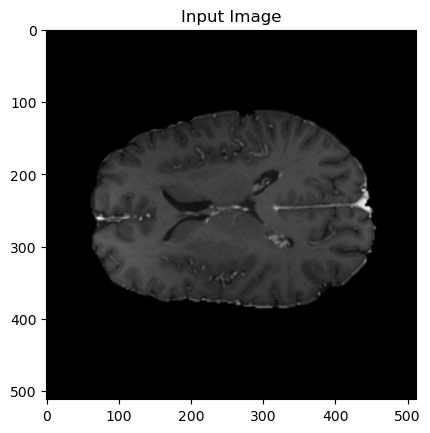

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, img_size=(512, 512)):
    # Load the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)  # Assuming grayscale MRI
    
    # Resize the image to the required dimensions
    img = tf.image.resize(img, img_size)
    
    # Normalize pixel values between 0 and 1
    img = img / 255.0
    
    # Add a batch dimension (required for the model input)
    img = tf.expand_dims(img, axis=0)
    
    return img

# Example usage:
image_path = r"C:\Users\priya\Documents\DL project\61_processed_image.png"
input_image = load_and_preprocess_image(image_path)

# Verify image dimensions and pixel range
print(f"Image shape: {input_image.shape}")  # Should be (1, 512, 512, 1)
print(f"Pixel values range: [{tf.reduce_min(input_image).numpy()}, {tf.reduce_max(input_image).numpy()}]")

# Optionally display the image
plt.imshow(np.squeeze(input_image), cmap='gray')
plt.title("Input Image")
plt.show()


In [ ]:
def build_generator(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    
    # Encoder
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Decoder
    model.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid'))
    
    return model

input_shape = (512, 512, 1)
generator = build_generator(input_shape)
generator.compile(optimizer='adam', loss='mse')


In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, save_path='model_checkpoint'):
        super(CustomCallback, self).__init__()
        self.image = image
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 50 == 0:
            # Reconstruct the image using the model
            reconstructed_image = self.model.predict(self.image)
            
            # Reshape the reconstructed image for display
            reconstructed_image = np.squeeze(reconstructed_image)  # Remove extra dimensions
            
            # Plot and display the reconstructed image
            plt.figure(figsize=(5, 5))
            plt.imshow(reconstructed_image, cmap='gray')
            plt.title(f'Reconstructed Image at Epoch {epoch + 1}')
            plt.axis('off')
            plt.show()
            
            # Save the model
            self.model.save(f'{self.save_path}_epoch_{epoch + 1}.h5')

# Initialize the callback
callback = CustomCallback(image=image_input)


In [ ]:
generator.fit(image_input, image_input,
              epochs=500,
              batch_size=1,
              callbacks=[callback])


In [ ]:
def build_generator(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    
    # Encoder
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Decoder
    model.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid', kernel_initializer='he_normal'))
    
    return model

generator = build_generator(input_shape)


In [ ]:
generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')


In [ ]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=ssim_loss)


In [ ]:
def combined_loss(y_true, y_pred):
    ssim_loss_value = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    mse_loss_value = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse_loss_value + 0.5 * ssim_loss_value

generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=combined_loss)


In [ ]:
def build_generator(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    
    # Encoder
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Decoder
    model.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid', kernel_initializer='he_normal'))
    
    return model


In [ ]:
generator.fit(image_input, image_input,
              epochs=500,
              batch_size=1,
              callbacks=[callback])

In [ ]:
generator.save('model_checkpoint_epoch_110.h5')

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Load the tumor-infected brain image
test_image_path = 'test/processed_image.png'
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
test_image = test_image / 255.0  # Normalize to [0, 1]
test_image_input = np.expand_dims(test_image, axis=(0, -1))  # Reshape to (1, 512, 512, 1)

# Load the actual tumor mask
mask_image_path = 'test/processed_mask.png'
mask_image = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
mask_image = mask_image / 255.0  # Normalize to [0, 1]


In [ ]:
# Load the trained model (Assuming the latest model checkpoint is loaded)
generator = tf.keras.models.load_model('model_checkpoint_epoch_500.h5', custom_objects={'ssim_loss': ssim_loss})

# Reconstruct the healthy brain
reconstructed_image = generator.predict(test_image_input)
reconstructed_image = np.squeeze(reconstructed_image)  # Remove the batch dimension, shape becomes (512, 512)


In [ ]:
# Calculate the difference between the tumor-infected brain and the reconstructed image
difference_image = np.abs(test_image - reconstructed_image)
# Apply a threshold to highlight the difference more clearly
#threshold = 0.35  # Adjust this based on the model's output
#difference_image = (difference_image > threshold).astype(np.float32)

# Visualize the difference image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image, cmap='gray')
plt.title('Original Tumor Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(difference_image, cmap='gray')
plt.title('Difference Image')
plt.axis('off')
plt.show()


In [ ]:
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# Binarize the difference image (this may require thresholding based on the range of values)
threshold = 0.5
predicted_mask = (difference_image > threshold).astype(np.float32)

# Compute IoU
iou_score = compute_iou(predicted_mask, mask_image)

# Print the IoU score
print(f'IoU Score: {iou_score:.4f}')


In [ ]:
# Display the reconstructed healthy brain
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Healthy Brain')
plt.axis('off')

# Display the difference image
plt.subplot(1, 3, 2)
plt.imshow(difference_image, cmap='gray')
plt.title('Difference Image')
plt.axis('off')

# Display the actual tumor mask
plt.subplot(1, 3, 3)
plt.imshow(mask_image, cmap='gray')
plt.title('Actual Tumor Mask')
plt.axis('off')
plt.show()

# Print the IoU score
print(f'IoU Score: {iou_score:.4f}')


In [ ]:
print()

In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf

# Generator Network
def build_generator(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    
    # Encoder
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Decoder
    model.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid'))
    
    return model

# Discriminator Network
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model


In [ ]:
class WGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, discriminator_steps=5, gp_weight=10.0):
        super(WGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.discriminator_steps = discriminator_steps
        self.gp_weight = gp_weight
    
    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")
    
    def gradient_penalty(self, real_images, fake_images):
        batch_size = tf.shape(real_images)[0]
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolated = alpha * real_images + (1 - alpha) * fake_images
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    
    def train_step(self, data):
        real_images = data
        
        # Train the discriminator for `discriminator_steps` steps
        for _ in range(self.discriminator_steps):
            with tf.GradientTape() as tape:
                fake_images = self.generator(real_images)
                fake_logits = self.discriminator(fake_images)
                real_logits = self.discriminator(real_images)
                
                d_cost = self.d_loss_fn(real_logits, fake_logits)
                gp = self.gradient_penalty(real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight
            
            d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        
        # Train the generator
        with tf.GradientTape() as tape:
            fake_images = self.generator(real_images)
            fake_logits = self.discriminator(fake_images)
            g_loss = self.g_loss_fn(fake_logits)
        
        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))
        
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}
    
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]


In [ ]:
# Define loss functions
def discriminator_loss(real_logits, fake_logits):
    return tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)

def generator_loss(fake_logits):
    return -tf.reduce_mean(fake_logits)

# Instantiate models
input_shape = (512, 512, 1)
generator = build_generator(input_shape)
discriminator = build_discriminator(input_shape)

# Instantiate WGAN
wgan = WGAN(generator=generator, discriminator=discriminator)

# Compile the WGAN model
wgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9),
    d_loss_fn=discriminator_loss,
    g_loss_fn=generator_loss
)

# Assuming you have your dataset in `train_dataset`
wgan.fit(image_input, epochs=200, batch_size=1, callbacks=[callback])




In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os

# Step 1: Define the Generator and Discriminator

def build_generator(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid'))
    
    return model

def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

# Step 2: Define WGAN Class

class WGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, discriminator_steps=5, gp_weight=10.0):
        super(WGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.discriminator_steps = discriminator_steps
        self.gp_weight = gp_weight
    
    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")
    
    def gradient_penalty(self, real_images, fake_images):
        batch_size = tf.shape(real_images)[0]
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolated = alpha * real_images + (1 - alpha) * fake_images
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    
    def train_step(self, data):
        real_images = data
        
        # Train the discriminator for `discriminator_steps` steps
        for _ in range(self.discriminator_steps):
            with tf.GradientTape() as tape:
                fake_images = self.generator(real_images)
                fake_logits = self.discriminator(fake_images)
                real_logits = self.discriminator(real_images)
                
                d_cost = self.d_loss_fn(real_logits, fake_logits)
                gp = self.gradient_penalty(real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight
            
            d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        
        # Train the generator
        with tf.GradientTape() as tape:
            fake_images = self.generator(real_images)
            fake_logits = self.discriminator(fake_images)
            g_loss = self.g_loss_fn(fake_logits)
        
        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))
        
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}
    
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

# Step 3: Custom Callback

class CustomWGANCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_interval, generator, test_image, save_dir="models", image_dir="images"):
        self.save_interval = save_interval
        self.generator = generator
        self.test_image = test_image
        self.save_dir = save_dir
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.save_interval == 0:
            # Save the generator model
            model_path = f"{self.save_dir}/generator_epoch_{epoch}.h5"
            self.generator.save(model_path)
            print(f"Model saved at {model_path}")

            # Generate the reconstructed image
            reconstructed_image = self.generator(self.test_image, training=False)
            
            # Save the reconstructed image
            reconstructed_image = (reconstructed_image[0, :, :, 0] * 255).numpy().astype("uint8")
            image_path = f"{self.image_dir}/reconstructed_epoch_{epoch}.png"
            tf.keras.preprocessing.image.save_img(image_path, reconstructed_image)
            print(f"Reconstructed image saved at {image_path}")

# Step 4: Load Single Image and Prepare Dataset

def load_single_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) / 255.0
    image = np.expand_dims(image, axis=-1).astype(np.float32)  # Shape: (height, width, channels)
    image = np.expand_dims(image, axis=0)  # Shape: (1, height, width, channels)
    return tf.convert_to_tensor(image)

# Load single image
image_path = '61_processed_image.png'  # Update with your image path
single_image = load_single_image(image_path)

# Define model and training parameters
input_shape = (512, 512, 1)
generator = build_generator(input_shape)
discriminator = build_discriminator(input_shape)

wgan = WGAN(generator=generator, discriminator=discriminator)

wgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9),
    d_loss_fn=lambda real, fake: tf.reduce_mean(fake) - tf.reduce_mean(real),
    g_loss_fn=lambda fake: -tf.reduce_mean(fake)
)

# Create directories for saving models and images if they don't exist
os.makedirs("models", exist_ok=True)
os.makedirs("images", exist_ok=True)

# Instantiate and set up the custom callback
save_interval = 100
callback = CustomWGANCallback(save_interval, generator, single_image)

# Create a dataset with the single image
train_dataset = tf.data.Dataset.from_tensor_slices(single_image).batch(1)

# Training loop
epochs = 1000
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for batch in train_dataset:
        wgan.train_step(batch)
    
    # Call the callback at the end of the epoch
    callback.on_epoch_end(epoch)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def build_generator(latent_dim):
    model = tf.keras.Sequential([
        layers.Dense(8*8*512, activation='relu', input_dim=latent_dim),
        layers.Reshape((8, 8, 512)),
        
        layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same', activation='relu'),
        layers.BatchNormalization(),
        
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', activation='relu'),
        layers.BatchNormalization(),
        
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu'),
        layers.BatchNormalization(),
        
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu'),
        layers.BatchNormalization(),
        
        layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', activation='relu'),
        layers.BatchNormalization(),
        
        layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', activation='sigmoid')
    ])
    return model

latent_dim = 100
generator = build_generator(latent_dim)
generator.summary()


In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(512, 512, 1)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        
        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()


In [ ]:
def build_encoder(latent_dim):
    model = tf.keras.Sequential([
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(512, 512, 1)),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(latent_dim)
    ])
    return model

encoder = build_encoder(latent_dim)
encoder.summary()


In [ ]:
#def wasserstein_loss(y_true, y_pred):
#    return tf.reduce_mean(y_true * y_pred)


In [ ]:
class WGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, encoder, latent_dim):
        super(WGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.encoder = encoder
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, e_optimizer, loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.e_optimizer = e_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Ensure the generated images match the shape of real images
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)

        # Combine generated and real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Create labels
        labels = tf.concat([tf.ones((batch_size, 1)), -tf.ones((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Train generator
        misleading_labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            fake_predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, fake_predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Train encoder with SSIM loss
        with tf.GradientTape() as tape:
            encoded_images = self.encoder(real_images)
            reconstructed_images = self.generator(encoded_images)
            ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(real_images, reconstructed_images, max_val=1.0))
        grads = tape.gradient(ssim_loss, self.encoder.trainable_weights)
        self.e_optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss, "ssim_loss": ssim_loss}


In [ ]:
import os
import matplotlib.pyplot as plt

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, generator, encoder, real_images, save_interval=100):
        super(CustomCallback, self).__init__()
        self.generator = generator
        self.encoder = encoder
        self.real_images = real_images
        self.save_interval = save_interval
        self.save_dir = 'model_checkpoints'
        os.makedirs(self.save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.save_interval == 0:
            # Save the model
            model_path = os.path.join(self.save_dir, f'model_epoch_{epoch}.h5')
            self.model.save_weights(model_path)
            print(f'Model saved at {model_path}')

            # Generate a reconstructed image
            latent_vector = self.encoder.predict(self.real_images)
            reconstructed_image = self.generator.predict(latent_vector)
            
            # Plot and save the reconstructed image (show only one channel for simplicity)
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.title("Original Image")
            plt.imshow(self.real_images[0, :, :, 0], cmap='gray')  # Showing the first channel

            plt.subplot(1, 2, 2)
            plt.title("Reconstructed Image")
            plt.imshow(reconstructed_image[0, :, :, 0], cmap='gray')  # Showing the first channel
            plt.show()


In [ ]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)


In [ ]:
# Compile the WGAN model
wgan = WGAN(generator=generator, discriminator=discriminator, encoder=encoder, latent_dim=latent_dim)
wgan.compile(
    d_optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005),
    g_optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005),
    e_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=wasserstein_loss
)

image_path = '61_processed_image.png'


# Load and preprocess the real image
real_image = io.imread(image_path, as_gray=True)
real_image = real_image / 255.0
real_image = np.expand_dims(real_image, axis=0)
real_image = np.expand_dims(real_image, axis=-1)

# Instantiate the callback with real images
custom_callback = CustomCallback(generator=generator, encoder=encoder, real_images=real_image, save_interval=100)

# Train the model
wgan.fit(real_image, epochs=1000, batch_size=1, callbacks=[custom_callback])



In [ ]:
# Generate a latent vector from the encoder
latent_vector = encoder.predict(image)

# Generate the reconstructed image
reconstructed_image = generator.predict(latent_vector)

# Calculate the anomaly
anomaly = np.abs(image - reconstructed_image)

# Visualize the original image, reconstructed image, and anomaly
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image[0, :, :, 0], cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image[0, :, :, 0], cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Anomaly')
plt.imshow(anomaly[0, :, :, 0], cmap='hot')

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io

In [ ]:
def build_generator(img_shape):
    model = tf.keras.Sequential()
    model.add(layers.Dense(128 * 128 * 256, activation="relu", input_shape=(100,)))
    model.add(layers.Reshape((128, 128, 256)))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    model.add(layers.Conv2D(1, kernel_size=7, padding="same", activation="tanh"))
    return model


In [ ]:
def build_discriminator(img_shape):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, input_shape=img_shape, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(512, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [ ]:
class WGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Train the discriminator with real and generated images
        for _ in range(5):  # 5 steps of discriminator for 1 step of generator
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors)
                real_logits = self.discriminator(real_images)
                fake_logits = self.discriminator(fake_images)
                d_cost = self.d_loss_fn(real_logits, fake_logits)
            d_gradient = tape.gradient(d_cost, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            fake_logits = self.discriminator(generated_images)
            g_cost = self.g_loss_fn(fake_logits)
        g_gradient = tape.gradient(g_cost, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))

        return {"d_loss": d_cost, "g_loss": g_cost}

In [ ]:
def discriminator_loss(real_logits, fake_logits):
    return tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)

def generator_loss(fake_logits):
    return -tf.reduce_mean(fake_logits)


In [ ]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100, img_dir="generated_images"):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.img_dir = img_dir
        if not os.path.exists(img_dir):
            os.makedirs(img_dir)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5 + 127.5).numpy()
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(self.img_dir, f"generated_img_{epoch}_{i}.png"))
        if (epoch + 1) % 100 == 0:
            self.model.generator.save(os.path.join(self.img_dir, f"generator_epoch_{epoch+1}.h5"))

In [ ]:
img_shape = (512, 512, 1)
latent_dim = 100

generator = build_generator(img_shape)
discriminator = build_discriminator(img_shape)

wgan = WGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

# Compile the WGAN
d_optimizer = RMSprop(learning_rate=0.005)
g_optimizer = RMSprop(learning_rate=0.00005)
wgan.compile(d_optimizer=d_optimizer, g_optimizer=g_optimizer,
             d_loss_fn=discriminator_loss, g_loss_fn=generator_loss)

# Training the Model
# Assuming train_images is your dataset with images normalized to [-1, 1]
#train_images = np.expand_dims(np.array([plt.imread('61_processed_image.png')])/127.5 - 1, axis=-1)

image_path = '61_processed_image.png'


# Load and preprocess the real image
real_image = io.imread(image_path, as_gray=True)
real_image = real_image / 127.5 - 1
real_image = np.expand_dims(real_image, axis=0)
train_images = np.expand_dims(real_image, axis=-1)


wgan.fit(train_images, batch_size=1, epochs=500, callbacks=[GANMonitor()])